# Convert "raw" Hugonnet et al (2021) geodetic per glacier dataset to a corrected dataset without outliers and missing glaciers
**Workflow:**
- reindex glaciers with GLIMS-ids to RGI-ids
- missing glaciers from the RGI are added to the dataset with their area and filled up with NaN-values
- Glaciers with connectivity level 2 are removed from the dataset (these are those glaciers that are strongly connected to the Greenland Ice Sheet). We don't want to do projections with them because they are already included in the GIS projections!
- the specific MB and std of all glaciers with MB standard deviations larger than a threshold (i.e. mean error plus three standard deviations of the error distribution) are also replaced by NaN-values (=outliers, in total 1532 glaciers). 
    - First an overall global threshold over all regions is computed, then this threshold is computed as well for every RGI region.
    - If the regional threshold is smaller than the global threshold, we use the global threshold (to not penalize regions that are well-measured), otherwise we use the regional threshold
- For each region a mean specific MB and a mean specific MB standard deviation is estimated. All RGI glaciers (connectivity level < 2) that have NaN-values (no measurements or outlier) are filled up with the regional means according to their RGI region. 

**In total, 8597 of 215547 glaciers are filled up with regional mean data, hence 4.0% of all RGI glaciers. This corresponds to only 0.25% of the total glacier area as mostly small glaciers had no geodetic data or are outliers. 1532 from them are "outlier" glaciers!** ([click here to get to a figure visualizing this](#id-dmdtda-stats-plot))

This method only fills up the dmdtda and err_dmdtda values. We are working at the moment to also fill up dhdt, err_dhdt, dvoldt and err_dvoldt ([see discussions at the end of this notebook](#id-analysis-problems-dhdt-dvoldt)), but this is not yet incorporated!

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import oggm
from oggm import utils
import pickle
pickle.HIGHEST_PROTOCOL = 4

## Convert csv to hdf file

In [3]:
fpath = 'https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv'
fpath = 'hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv'
df = pd.read_csv(fpath, index_col=0)

In [4]:
df

period      area    dhdt  err_dhdt    dvoldt  \
rgiid                                                                         
RGI60-01.00001  2000-01-01_2020-01-01  360000.0 -0.0150    0.2559   -5414.0   
RGI60-01.00001  2010-01-01_2020-01-01  360000.0 -0.0556    0.4645  -20003.0   
RGI60-01.00001  2000-01-01_2010-01-01  360000.0  0.0255    0.5059    9175.0   
RGI60-01.00002  2000-01-01_2020-01-01  558000.0 -0.2695    0.1653 -150361.0   
RGI60-01.00002  2010-01-01_2020-01-01  558000.0 -0.3410    0.3234 -190257.0   
...                               ...       ...     ...       ...       ...   
RGI60-19.02751  2000-01-01_2020-01-01   11000.0 -2.1611    0.8691  -23772.0   
RGI60-19.02751  2000-01-01_2010-01-01   11000.0 -2.1317    1.7586  -23449.0   
RGI60-19.02752  2000-01-01_2010-01-01  528000.0  0.1427    0.6371   75344.0   
RGI60-19.02752  2000-01-01_2020-01-01  528000.0 -0.0454    0.3407  -23981.0   
RGI60-19.02752  2010-01-01_2020-01-01  528000.0 -0.2335    0.5643 -123306.0   

                err_dvoldt      dmdt  err_dmdt  dmdtda  err_dmdtda  \
rgiid                                                                
RGI60-01.00001     92139.0 -0.000005  0.000078 -0.0128      0.2176   
RGI60-01.00001    167248.0 -0.000017  0.000142 -0.0472      0.3949   
RGI60-01.00001    182132.0  0.000008  0.000155  0.0217      0.4300   
RGI60-01.00002     93741.0 -0.000128  0.000080 -0.2290      0.1460   
RGI60-01.00002    181714.0 -0.000162  0.000155 -0.2898      0.2794   
...                    ...       ...       ...     ...         ...   
RGI60-19.02751     21979.0 -0.000020  0.000019 -1.8369      2.2891   
RGI60-19.02751     27483.0 -0.000020  0.000023 -1.8119      2.6080   
RGI60-19.02752    336536.0  0.000064  0.000286  0.1213      0.5421   
RGI60-19.02752    179916.0 -0.000020  0.000153 -0.0386      0.2897   
RGI60-19.02752    298432.0 -0.000105  0.000254 -0.1985      0.4814   

                perc_area_meas  perc_area_res  valid_obs  valid_obs_py  reg  
rgiid                                                                        
RGI60-01.00001           1.000          1.000      26.41         11.11    1  
RGI60-01.00001           1.000          1.000      18.30          6.32    1  
RGI60-01.00001           1.000          1.000       8.11          4.78    1  
RGI60-01.00002           1.000          1.000      26.21         16.23    1  
RGI60-01.00002           1.000          1.000      15.18          7.95    1  
...                        ...            ...        ...           ...  ...  
RGI60-19.02751           1.000          1.000       4.00          4.00   19  
RGI60-19.02751           1.000          1.000       0.00          0.00   19  
RGI60-19.02752           0.981          0.981       2.74          1.70   19  
RGI60-19.02752           0.981          0.981       6.91          5.15   19  
RGI60-19.02752           0.981          0.981       4.17          3.44   19  

[654390 rows x 15 columns]

In [5]:
df.to_hdf('hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.hdf', key='df')

## Convert Caucasus glaciers to RGI

In [6]:
df = pd.read_hdf('hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.hdf')

In [7]:
dfs = df.loc[df['period'] == '2000-01-01_2020-01-01']

In [8]:
len(dfs)

218130

the Caucasus glaciers (RGI region 12) have a GLIMS index instead of the RGI index:


In [9]:
not_rgi = np.array(['RGI60' not in s for s in dfs.index])
len(dfs.loc[not_rgi]), len(dfs.loc[~not_rgi])

(3516, 214614)

get dictionary that relates GLIMS to RGI for region 12 and then reindex them with the actual RGI id

In [10]:
url_glimsid = 'https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/12_GLIMSId_RGIId_dict.csv'
path_glimsid = utils.file_downloader(url_glimsid)
lookup = pd.read_csv(path_glimsid, header=None, index_col=0)[1].to_dict()

In [11]:
new_index = df.index.values.copy()
for i, rid in enumerate(new_index):
    if rid in lookup:
        new_index[i] = lookup[rid]

In [12]:
df_new = df.set_index(new_index)

there are still glaciers with GLIMS id from region 12. We will remove them!

In [13]:
not_rgi = np.array(['RGI60' not in s for s in df_new.index])
df_new.loc[not_rgi]

period    area  dhdt  err_dhdt  dvoldt  \
G039564E39446N  2010-01-01_2020-01-01  8000.0   NaN       NaN     NaN   
G039564E39446N  2000-01-01_2020-01-01  8000.0   NaN       NaN     NaN   
G039564E39446N  2000-01-01_2010-01-01  8000.0   NaN       NaN     NaN   
G039579E39451N  2000-01-01_2020-01-01  8000.0   NaN       NaN     NaN   
G039579E39451N  2000-01-01_2010-01-01  8000.0   NaN       NaN     NaN   
...                               ...     ...   ...       ...     ...   
G052226E35769N  2010-01-01_2020-01-01     0.0   NaN       NaN     NaN   
G052226E35769N  2000-01-01_2020-01-01     0.0   NaN       NaN     NaN   
G052227E35770N  2000-01-01_2010-01-01     0.0   NaN       NaN     NaN   
G052227E35770N  2010-01-01_2020-01-01     0.0   NaN       NaN     NaN   
G052227E35770N  2000-01-01_2020-01-01     0.0   NaN       NaN     NaN   

                err_dvoldt  dmdt  err_dmdt  dmdtda  err_dmdtda  \
G039564E39446N         NaN   NaN       NaN     NaN         NaN   
G039564E39446N         NaN   NaN       NaN     NaN         NaN   
G039564E39446N         NaN   NaN       NaN     NaN         NaN   
G039579E39451N         NaN   NaN       NaN     NaN         NaN   
G039579E39451N         NaN   NaN       NaN     NaN         NaN   
...                    ...   ...       ...     ...         ...   
G052226E35769N         NaN   NaN       NaN     NaN         NaN   
G052226E35769N         NaN   NaN       NaN     NaN         NaN   
G052227E35770N         NaN   NaN       NaN     NaN         NaN   
G052227E35770N         NaN   NaN       NaN     NaN         NaN   
G052227E35770N         NaN   NaN       NaN     NaN         NaN   

                perc_area_meas  perc_area_res  valid_obs  valid_obs_py  reg  
G039564E39446N             NaN            NaN        0.0           0.0   12  
G039564E39446N             NaN            NaN        0.0           0.0   12  
G039564E39446N             NaN            NaN        0.0           0.0   12  
G039579E39451N             NaN            NaN        0.0           0.0   12  
G039579E39451N             NaN            NaN        0.0           0.0   12  
...                        ...            ...        ...           ...  ...  
G052226E35769N             NaN            NaN        0.0           0.0   12  
G052226E35769N             NaN            NaN        0.0           0.0   12  
G052227E35770N             NaN            NaN        0.0           0.0   12  
G052227E35770N             NaN            NaN        0.0           0.0   12  
G052227E35770N             NaN            NaN        0.0           0.0   12  

[6330 rows x 15 columns]

those glaciers only come from RGI region 12

In [14]:
df_new.loc[not_rgi].reg.unique()

array([12])

Let's only use glaciers with RGI-index:

In [15]:
df_new = df_new.loc[~ not_rgi]

We create a template for the missing glaciers

In [16]:
template = df_new.copy(deep=True).iloc[0:3]

In [17]:
template[template.columns[1:]] = np.NaN
template['reg'] = 12

In [18]:
template

period  area  dhdt  err_dhdt  dvoldt  \
RGI60-01.00001  2000-01-01_2020-01-01   NaN   NaN       NaN     NaN   
RGI60-01.00001  2010-01-01_2020-01-01   NaN   NaN       NaN     NaN   
RGI60-01.00001  2000-01-01_2010-01-01   NaN   NaN       NaN     NaN   

                err_dvoldt  dmdt  err_dmdt  dmdtda  err_dmdtda  \
RGI60-01.00001         NaN   NaN       NaN     NaN         NaN   
RGI60-01.00001         NaN   NaN       NaN     NaN         NaN   
RGI60-01.00001         NaN   NaN       NaN     NaN         NaN   

                perc_area_meas  perc_area_res  valid_obs  valid_obs_py  reg  
RGI60-01.00001             NaN            NaN        NaN           NaN   12  
RGI60-01.00001             NaN            NaN        NaN           NaN   12  
RGI60-01.00001             NaN            NaN        NaN           NaN   12

In [19]:
path_rgi =  utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
rgi = pd.read_hdf(path_rgi)

In [21]:
n = len(df_new.loc[rgi['O1Region']!='12'][df_new.loc[rgi['O1Region']!='12'].period == '2000-01-01_2020-01-01'])
print('glaciers outside RGI region 12 inside geodetic dataset : {}'.format(n))
print('glaciers outside RGI region 12 in total from rgi : {}'.format(len(rgi.loc[rgi['O1Region']!='12'])))
print('glaciers in total in rgi : {}'.format(len(rgi)))

glaciers outside RGI region 12 inside geodetic dataset : 214614
glaciers outside RGI region 12 in total from rgi : 214614
glaciers in total in rgi : 216502


**OK so all glaciers are already in the data except the ones without lookup in region 12.**

First, add missing glaciers and the area of them to the geodetic dataset. 

In [22]:
to_add = []
for rid, s in rgi.loc[rgi['O1Region']=='12'].iterrows():
    if rid not in df_new.index:
        new_id = template.copy(deep=True)
        new_id.index = [rid]*3
        new_id['area'] = s['Area'] * 1e6
        to_add.append(new_id)
to_add = pd.concat(to_add)

In [23]:
df_new = pd.concat([df_new, to_add]).sort_index()

In [24]:
assert len(df_new) / 3 == len(rgi)

In [25]:
df_new = df_new.rename_axis('rgiid').sort_values(by = ['rgiid', 'period'])
df_new

period      area    dhdt  err_dhdt    dvoldt  \
rgiid                                                                         
RGI60-01.00001  2000-01-01_2010-01-01  360000.0  0.0255    0.5059    9175.0   
RGI60-01.00001  2000-01-01_2020-01-01  360000.0 -0.0150    0.2559   -5414.0   
RGI60-01.00001  2010-01-01_2020-01-01  360000.0 -0.0556    0.4645  -20003.0   
RGI60-01.00002  2000-01-01_2010-01-01  558000.0 -0.1980    0.3267 -110465.0   
RGI60-01.00002  2000-01-01_2020-01-01  558000.0 -0.2695    0.1653 -150361.0   
...                               ...       ...     ...       ...       ...   
RGI60-19.02751  2000-01-01_2020-01-01   11000.0 -2.1611    0.8691  -23772.0   
RGI60-19.02751  2010-01-01_2020-01-01   11000.0 -2.1904    1.5831  -24095.0   
RGI60-19.02752  2000-01-01_2010-01-01  528000.0  0.1427    0.6371   75344.0   
RGI60-19.02752  2000-01-01_2020-01-01  528000.0 -0.0454    0.3407  -23981.0   
RGI60-19.02752  2010-01-01_2020-01-01  528000.0 -0.2335    0.5643 -123306.0   

                err_dvoldt      dmdt  err_dmdt  dmdtda  err_dmdtda  \
rgiid                                                                
RGI60-01.00001    182132.0  0.000008  0.000155  0.0217      0.4300   
RGI60-01.00001     92139.0 -0.000005  0.000078 -0.0128      0.2176   
RGI60-01.00001    167248.0 -0.000017  0.000142 -0.0472      0.3949   
RGI60-01.00002    182728.0 -0.000094  0.000155 -0.1683      0.2792   
RGI60-01.00002     93741.0 -0.000128  0.000080 -0.2290      0.1460   
...                    ...       ...       ...     ...         ...   
RGI60-19.02751     21979.0 -0.000020  0.000019 -1.8369      2.2891   
RGI60-19.02751     26564.0 -0.000020  0.000023 -1.8619      2.5755   
RGI60-19.02752    336536.0  0.000064  0.000286  0.1213      0.5421   
RGI60-19.02752    179916.0 -0.000020  0.000153 -0.0386      0.2897   
RGI60-19.02752    298432.0 -0.000105  0.000254 -0.1985      0.4814   

                perc_area_meas  perc_area_res  valid_obs  valid_obs_py  reg  
rgiid                                                                        
RGI60-01.00001           1.000          1.000       8.11          4.78    1  
RGI60-01.00001           1.000          1.000      26.41         11.11    1  
RGI60-01.00001           1.000          1.000      18.30          6.32    1  
RGI60-01.00002           1.000          1.000      11.04          8.28    1  
RGI60-01.00002           1.000          1.000      26.21         16.23    1  
...                        ...            ...        ...           ...  ...  
RGI60-19.02751           1.000          1.000       4.00          4.00   19  
RGI60-19.02751           1.000          1.000       4.00          4.00   19  
RGI60-19.02752           0.981          0.981       2.74          1.70   19  
RGI60-19.02752           0.981          0.981       6.91          5.15   19  
RGI60-19.02752           0.981          0.981       4.17          3.44   19  

[649506 rows x 15 columns]

In [26]:
df_new.to_hdf('hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_reg12cor.hdf', key='df')

## Remove glaciers with connectivity level 2

Glaciers with connectivity level 2 are those glaciers that are strongly connected to the Greenland Ice Sheet. We don't want to do projections with them because they are already included in the GIS projections!

In [27]:
# there are some glaciers on connectivity level 2
len(rgi.loc[rgi['Connect'] == 2])

955

In [28]:
# check: they are only in RGI region 05 (Greenland)
rgi.loc[rgi['Connect'] == 2]['O1Region'].unique()

array(['05'], dtype=object)

In [29]:
valid_ids = rgi.loc[rgi['Connect'] != 2].index
c2_ids = rgi.loc[rgi['Connect'] == 2].index
df_new = df_new.loc[valid_ids].copy(deep=True)
rgi = rgi.loc[valid_ids].copy(deep=True)

In [30]:
len(rgi)

215547

## Remove outliers and fill missing 

In [31]:
dfs = df_new.loc[df_new.period == '2000-01-01_2020-01-01'].copy(deep=True)[['area', 'dmdtda', 'err_dmdtda', 'reg']]

statistics on the error of the specific mass balance from the geodetic data:

In [32]:
dfs.err_dmdtda.quantile([0.001, 0.01, 0.5, 0.99, 0.999])

0.001    0.075294
0.010    0.103500
0.500    0.222300
0.990    0.879962
0.999    2.051393
Name: err_dmdtda, dtype: float64

In [33]:
dfs.err_dmdtda.max()

13.7913

**we remove all glaciers where the error is larger than the mean error plus three standard deviations of the error distribution (i.e. all sigma threshold)** 

In [34]:
# SHOULD IT BE AREA WEIGHTED???? Maybe not
all_sigma_mean = dfs['err_dmdtda'].mean()
all_sigma_std = dfs['err_dmdtda'].std()
all_sigma_threshold = all_sigma_mean + 3 * all_sigma_std
print('all sigma threshold (global estimate):', np.round(all_sigma_threshold, 2))

all sigma threshold (global estimate): 0.83


In [35]:
periods = ['2000-01-01_2010-01-01', '2000-01-01_2020-01-01', '2010-01-01_2020-01-01']
# We filter and fill all periods based on the 20 year threshold
df_filled = df_new.copy()[['period', 'area', 'dmdtda', 'err_dmdtda', 'reg']]
df_filled['is_cor'] = False
for reg in range(1, 20):
    
    dfs_subset = dfs.loc[dfs['reg'] == reg]
    
    # Too high of sigma causes large issues for model
    # compute regional threshold for every region
    reg_sigma_mean = dfs_subset['err_dmdtda'].mean()
    reg_sigma_std = dfs_subset['err_dmdtda'].std()
    reg_sigma_threshold = reg_sigma_mean + 3 * reg_sigma_std
    
    # Don’t penalize regions that are well-measured, so use all threshold as minimum:
    # if the regional threshold is smaller than the global threshold,
    # we use the global threshold, otherwise we use the regional threshold
    if reg_sigma_threshold < all_sigma_threshold:
        reg_sigma_threshold = all_sigma_threshold
        
    to_replace = dfs_subset.loc[dfs_subset['err_dmdtda'] > reg_sigma_threshold]
    to_keep = dfs_subset.loc[dfs_subset['err_dmdtda'] <= reg_sigma_threshold]
    
    print(reg, len(dfs_subset), len(to_replace),  np.round(reg_sigma_threshold, 2))
        
    df_filled.loc[to_replace.index, 'dmdtda'] = np.NaN
    df_filled.loc[to_replace.index, 'err_dmdtda'] = np.NaN
    
    # Replace nan values - SHOULD BE AREA WEIGHTED????
    for period in periods:
        
        # indices of glaciers without dmdtda data (because missing or outlier)
        loc_no = (df_filled['reg'] == reg) & (df_filled['dmdtda'].isnull()) & (df_filled['period'] == period)
        # indices of glaciers with dmdtda data
        loc_yes = (df_filled['reg'] == reg) & (~ df_filled['dmdtda'].isnull()) & (df_filled['period'] == period)
        
        # replace the nan-values from the missing and outlier glaciers with the regional mean and standard deviation mean 
        # Note that every glacier without "usable" geodetic data will get the same dmdtda and err_dmdtda 
        # (independent of the glacier characteristics such as size, elevation) !!!
        df_filled.loc[loc_no,  'dmdtda'] = df_filled.loc[loc_yes,  'dmdtda'].mean()
        df_filled.loc[loc_no,  'err_dmdtda'] = df_filled.loc[loc_yes,  'err_dmdtda'].mean()
        df_filled.loc[loc_no,  'is_cor'] = True

1 27108 182 0.83
2 18855 190 0.83
3 4556 14 0.83
4 7415 8 0.83
5 19306 27 0.83
6 568 1 0.83
7 1615 1 0.83
8 3417 30 0.83
9 1069 0 0.83
10 5151 77 1.11
11 3927 57 1.19
12 1888 19 0.83
13 54429 200 0.83
14 27988 238 0.83
15 13119 128 0.83
16 2939 46 0.92
17 15908 228 1.53
18 3537 29 1.08
19 2752 47 1.45


In [36]:
dfs_filled = df_filled.loc[df_new.period == '2000-01-01_2020-01-01']

In [37]:
dfs_filled.err_dmdtda.quantile([0.001, 0.01, 0.5, 0.99, 0.999])

0.001    0.075754
0.010    0.104000
0.500    0.226100
0.990    0.739012
0.999    1.154537
Name: err_dmdtda, dtype: float64

In [38]:
dfs_filled.err_dmdtda.max()

1.5258

In [39]:
dfs_filled.dmdtda.max()

8.034

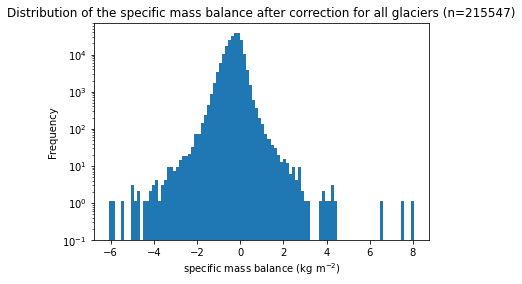

In [40]:
fig, ax = plt.subplots()
dfs_filled.dmdtda.plot(kind='hist', bins=100, bottom=0.1);
ax.set_yscale('log')
plt.title(f'Distribution of the specific mass balance after correction for all glaciers (n={len(dfs_filled)})')
plt.xlabel(r'specific mass balance (kg m$^{-2}$)');

In [41]:
# relative amount of glacier area with a positive specific mass balance
dfs_filled.loc[dfs_filled.dmdtda > 0].area.sum() / dfs_filled.area.sum()

0.131646168795644

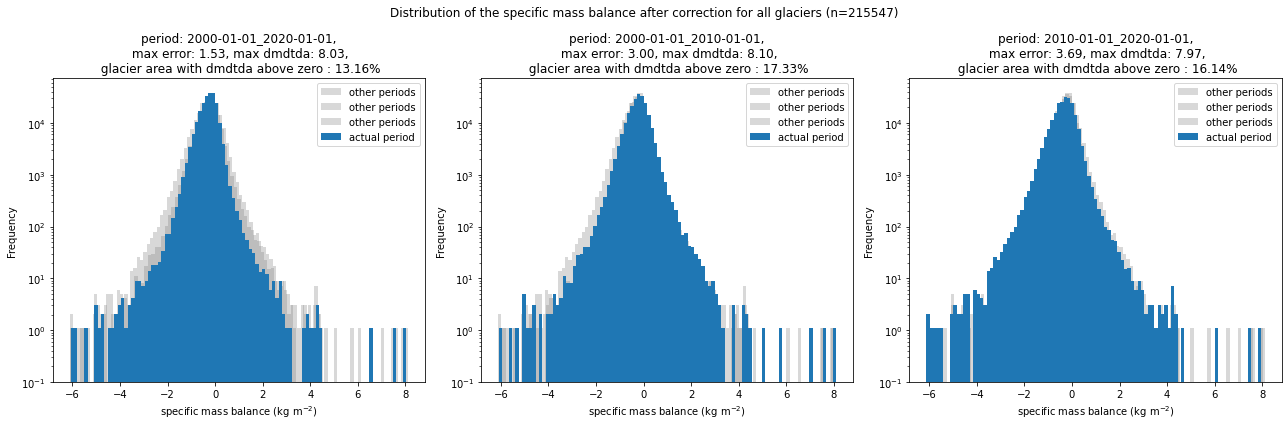

In [42]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))
plt.suptitle(f'Distribution of the specific mass balance after correction for all glaciers (n={len(dfs_filled)})')
for k,period in enumerate([periods[1], periods[0], periods[2]]):
    for _,period2 in enumerate([periods[1], periods[0], periods[2]]):
        dfs_filled = df_filled.loc[df_new.period == period2]
        dfs_filled.dmdtda.plot(kind='hist', bins=100, bottom=0.1, alpha=0.3, ax = ax[k], color = 'grey', label='other periods');
    dfs_filled = df_filled.loc[df_new.period == period]
    dfs_filled.dmdtda.plot(kind='hist', bins=100, bottom=0.1, alpha=1, ax = ax[k], label = 'actual period');
    ax[k].set_yscale('log')
    ax[k].set_title('period: {},\n max error: {:0.2f}, max dmdtda: {:0.2f},\n glacier area with dmdtda above zero : {:0.2f}%'.format(period,
                                                                                                          dfs_filled.err_dmdtda.max(),
                                                                                                          dfs_filled.dmdtda.max(),
                                                                                                          dfs_filled.loc[dfs_filled.dmdtda > 0].area.sum()*100 / dfs_filled.area.sum()))
    ax[k].legend()
    ax[k].set_xlabel(r'specific mass balance (kg m$^{-2}$)');
plt.tight_layout()

In [43]:
# check: are there any glaciers left with nan-values?
df_filled.loc[df_filled['dmdtda'].isnull()]
# No!

Empty DataFrame
Columns: [period, area, dmdtda, err_dmdtda, reg, is_cor]
Index: []

save the corrected dataset to use it then to calibrate the mass-balance model

In [44]:
df_filled.to_hdf('hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_filled.hdf', key='df')

## Some more statistics

In [45]:
# first repeat the filling by using the medians instead of means (just for a check)!
df_filled_med = df_new.copy()[['period', 'area', 'dmdtda', 'err_dmdtda', 'reg']]
df_filled_med['is_cor'] = False
for reg in range(1, 20):
    
    dfs_subset = dfs.loc[dfs['reg'] == reg]
    
    # Too high of sigma causes large issues for model
    # compute regional threshold for every region
    reg_sigma_mean = dfs_subset['err_dmdtda'].mean()
    reg_sigma_std = dfs_subset['err_dmdtda'].std()
    reg_sigma_threshold = reg_sigma_mean + 3 * reg_sigma_std
    
    # Don’t penalize regions that are well-measured, so use all threshold as minimum:
    # if the regional threshold is smaller than the global threshold,
    # we use the global threshold, otherwise we use the regional threshold
    if reg_sigma_threshold < all_sigma_threshold:
        reg_sigma_threshold = all_sigma_threshold
        
    to_replace = dfs_subset.loc[dfs_subset['err_dmdtda'] > reg_sigma_threshold]
    to_keep = dfs_subset.loc[dfs_subset['err_dmdtda'] <= reg_sigma_threshold]
    
    #print(reg, len(dfs_subset), len(to_replace),  np.round(reg_sigma_threshold, 2))
        
    df_filled_med.loc[to_replace.index, 'dmdtda'] = np.NaN
    df_filled_med.loc[to_replace.index, 'err_dmdtda'] = np.NaN
    
    # Replace nan values - SHOULD BE AREA WEIGHTED????
    for period in periods:
        
        # indices of glaciers without dmdtda data (because missing or outlier)
        loc_no = (df_filled_med['reg'] == reg) & (df_filled_med['dmdtda'].isnull()) & (df_filled_med['period'] == period)
        # indices of glaciers with dmdtda data
        loc_yes = (df_filled_med['reg'] == reg) & (~ df_filled_med['dmdtda'].isnull()) & (df_filled_med['period'] == period)
        
        # replace the nan-values from the missing and outlier glaciers with the regional median and standard deviation median 
        # Note that every glacier without "usable" geodetic data will get the same dmdtda and err_dmdtda 
        # (independent of the glacier characteristics such as size, elevation) !!!
        df_filled_med.loc[loc_no,  'dmdtda'] = df_filled_med.loc[loc_yes,  'dmdtda'].median() 
        df_filled_med.loc[loc_no,  'err_dmdtda'] = df_filled_med.loc[loc_yes,  'err_dmdtda'].median()
        df_filled_med.loc[loc_no,  'is_cor'] = True

<a id='id-dmdtda-stats-plot'></a>

8597 out of 215547 glaciers were filled up with regional mean data, hence 3.99%.
0.25% of the glacier area was refilled with regional mean data


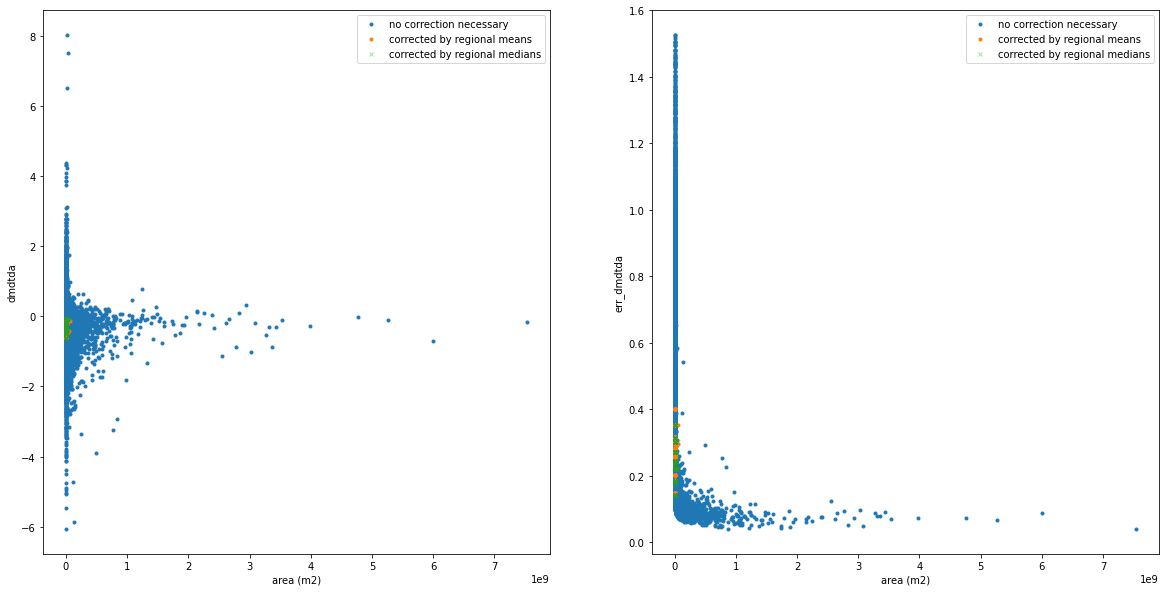

In [46]:
df_filled_per = df_filled[df_filled['period']=='2000-01-01_2020-01-01']
n_cor = len(df_filled_per.loc[df_filled_per['is_cor']])
n_total = len(df_filled_per)
area_cor = df_filled_per.loc[df_filled_per['is_cor']].area
area_cor_sum = area_cor.sum()
area_cor_med = area_cor.median()
print(f'{n_cor} out of {n_total} glaciers were filled up with regional mean data, hence {np.round(n_cor*100/n_total,2)}%.')
print(f'{np.round(area_cor_sum*100/df_filled_per.area.sum(),2)}% of the glacier area was refilled with regional mean data')

# same but using instead regional medians for corrections
df_filled_per_med = df_filled_med[df_filled_med['period']=='2000-01-01_2020-01-01']

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(df_filled_per.loc[~df_filled_per['is_cor']].area,df_filled_per.loc[~df_filled_per['is_cor']].dmdtda, '.', label='no correction necessary')
plt.plot(df_filled_per.loc[df_filled_per['is_cor']].area,df_filled_per.loc[df_filled_per['is_cor']].dmdtda, '.', 
         label='corrected by regional means')
plt.plot(df_filled_per_med.loc[df_filled_per_med['is_cor']].area,
         df_filled_per_med.loc[df_filled_per['is_cor']].dmdtda, 'x',alpha=0.4, ms=4,
         label='corrected by regional medians')
plt.legend()
plt.xlabel('area (m2)')
plt.ylabel('dmdtda')

plt.subplot(122)
plt.plot(df_filled_per.loc[~df_filled_per['is_cor']].area,df_filled_per.loc[~df_filled_per['is_cor']].err_dmdtda, '.', label='no correction necessary')
plt.plot(df_filled_per.loc[df_filled_per['is_cor']].area,df_filled_per.loc[df_filled_per['is_cor']].err_dmdtda, '.', 
         label='corrected by regional means')
plt.plot(df_filled_per_med.loc[df_filled_per_med['is_cor']].area,df_filled_per_med.loc[df_filled_per_med['is_cor']].err_dmdtda,
         'x', alpha=0.4, ms=4,label='corrected by regional medians')
plt.legend()
plt.xlabel('area (m2)')
plt.ylabel('err_dmdtda');


- Glaciers that needed to be filled up with regional means are small 
- There is no direct relationship between area and dmdtda. Glaciers that are small but do not need any corrections can have both very negative or very positive dmdta. In addition the standard deviation increases with decreasing area of a glacier. However, the variability of the standard deviation is large for small glaciers
- Shouldn't we increase the standard deviation of the corrected small glaciers ?! 
    - maybe yes, but just using the medians instead even decreases the standard deviation!
    - this is because there are much more small glaciers than larger ones. So, as we do not weight over the area while averaging, it is mostly the small glaciers that decide over the regional mean dmdtda and err_dmdtda, which is what we want! So maybe this simple method is just ok. 


<a id='id-analysis-problems-dhdt-dvoldt'></a>

## How can we best fill up dhdt, err_dhdt and dvoldt, err_dvoldt ?!

- We have not yet found the best solution for that
- in the following there are just some plots and a possible way to interpolate dvoldt and err_dvoldt using an area-dependency. However, this is not yet incorporated anywhere and needs further tuning!

**Some further thoughts about that:**
- for dhdt and its error, probably the same method as used with dmdtda is ok.
- For  dvoldt and dvoldt_err, we really should somehow take into account that the missing glaciers are small .
     - E.g. take those glaciers with data from each region that are within 95% range of glacier area distribution from the missing glaciers, and then use that mean / median ?
        - but if we do this, we could also apply it for all measures to simplify it ...
     - Probably this is still bad. So, we rather need to take those glaciers within the area range of the missing glaciers, and use the relation with the area to fit the missing dvoldt & err_dvoldt values (because dVdt depends strongly on the area).
    - globally this works more or less, but it would be better to repeat this regionally 
- but of course there are other methods. E.g. Loris Compagno (2021) uses estimates from the nearest glacier with similar area to fill up the data. If this is better is not clear. 
- For global scale it is probably not important. But when doing smaller-scale studies, it can get important to think about which filling method to apply! ... at the end for all filling stuff, one could do some kind of "small"-cross validation  to check how well or bad the method is?!

----

In [47]:
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression

In [48]:
# Let's only look at the 20-year period
df_new_per = df_new[df_new['period']=='2000-01-01_2020-01-01']

### Let's look at dhdt and err_dhdt first
- it looks quite similar as dmdtda,
- so probably we can apply the same approach as done with dmdtda

Text(0, 0.5, 'dhdt')

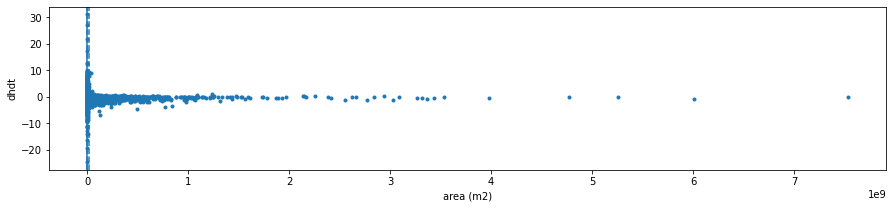

In [49]:
plt.figure(figsize=(15,3))
plt.plot(df_new_per.area, df_new_per.dhdt, '.')
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area,0.025), ls='--')
plt.axvline(df_filled[df_filled.is_cor].area.median())
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area,0.975), ls='--')
plt.xlabel('area (m2)')
plt.ylabel('dhdt')

**Let's look at only the glaciers area range with glaciers that need to be corrected:**

In [50]:
# Let's only look at those glaciers that have are in the same area range as the glaciers that need corrections:
df_new_per_small = df_new_per[(df_new_per.area >= df_filled_per[df_filled_per.is_cor].area.min()) & (df_new_per.area <= df_filled_per[df_filled_per.is_cor].area.max())]
df_new_per_small = df_new_per_small.dropna()

Text(0, 0.5, 'dhdt')

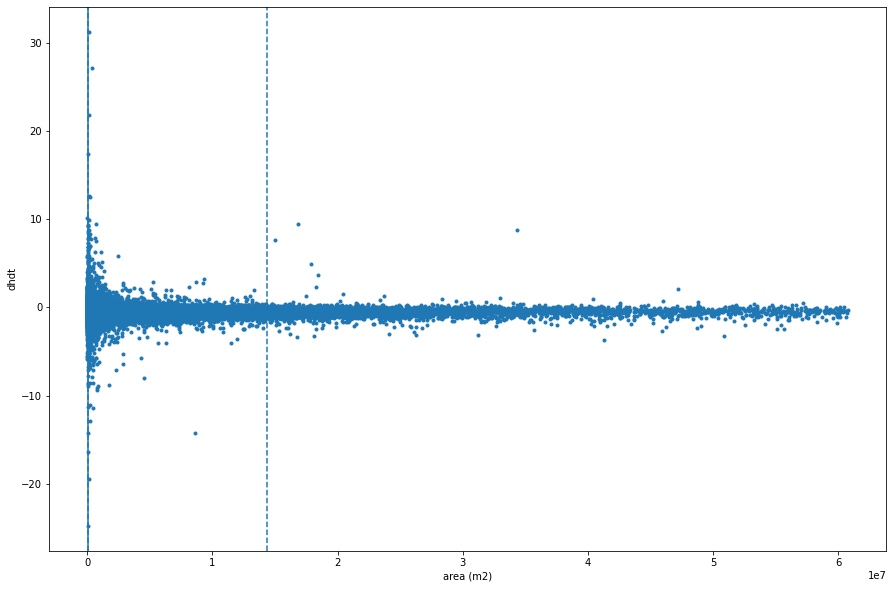

In [51]:
plt.figure(figsize=(15,10))
plt.plot(df_new_per_small.area, df_new_per_small.dhdt, '.')
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area,0.025), ls='--')
plt.axvline(df_filled[df_filled.is_cor].area.median())
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area,0.975), ls='--')
plt.xlabel('area (m2)')
plt.ylabel('dhdt')

Text(0, 0.5, 'dhdt')

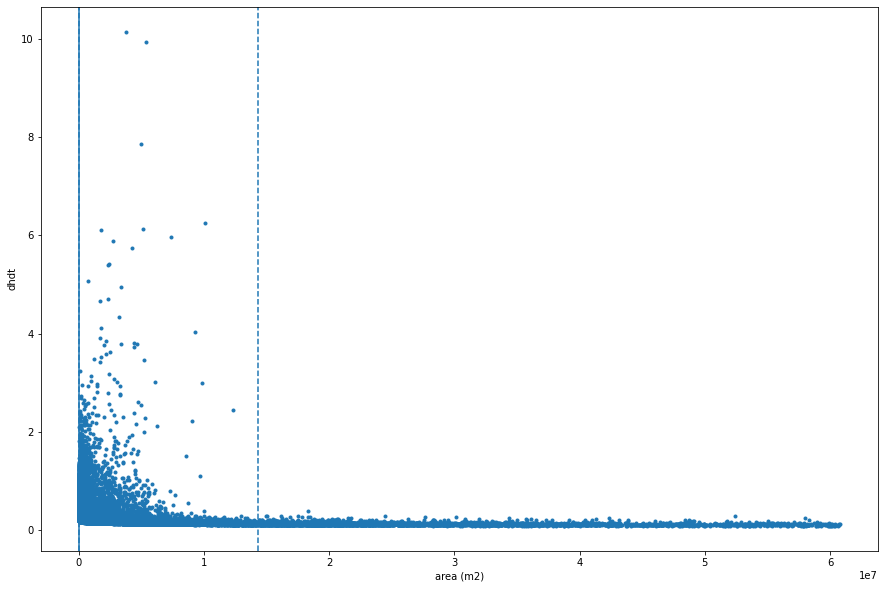

In [52]:
plt.figure(figsize=(15,10))
plt.plot(df_new_per_small.area, df_new_per_small.err_dhdt, '.')
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area,0.025), ls='--')
plt.axvline(df_filled[df_filled.is_cor].area.median())
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area,0.975), ls='--')
plt.xlabel('area (m2)')
plt.ylabel('dhdt')

### What about dvoldt and err_dvoldt?


Text(0, 0.5, 'dvoldt (m3)')

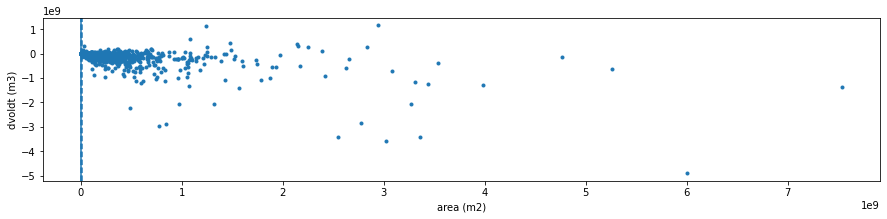

In [53]:
plt.figure(figsize=(15,3))
plt.plot(df_new_per.area, df_new_per.dvoldt, '.')
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area, 0.025), ls='--')
plt.axvline(df_filled[df_filled.is_cor].area.median())
plt.axvline(np.quantile(df_filled[~df_filled.is_cor].area, 0.975), ls='--')
plt.xlabel('area (m2)')
plt.ylabel('dvoldt (m3)')


- For large glaciers, there is no relationship between dvoldt and area (> 97.5\%). However, those glaciers that need to be filled up with values are rather smaller

**Let's look at only the glaciers area range with glaciers that need to be corrected:**

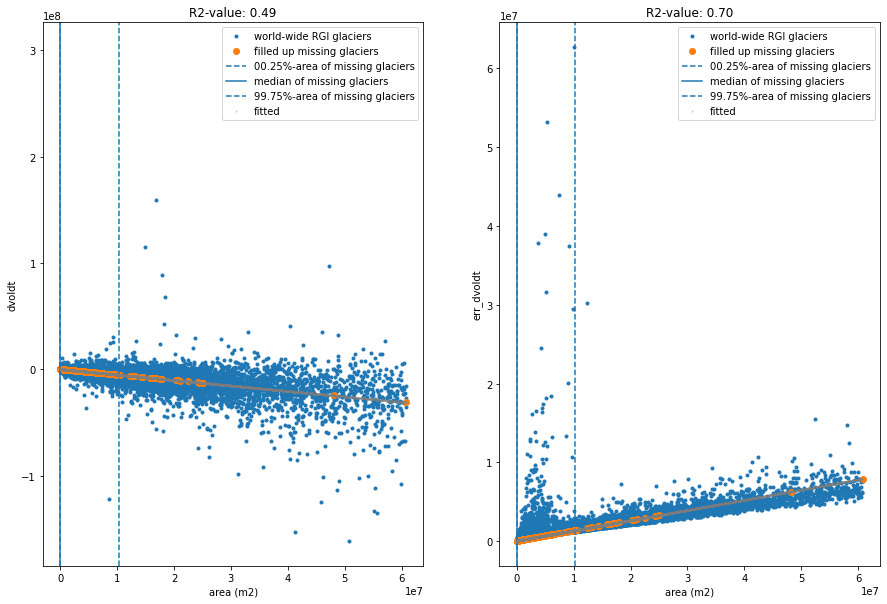

In [54]:
plt.figure(figsize=(15,10))
plt.subplot(121)
reg = LinearRegression().fit(np.atleast_2d(df_new_per_small.area.values).T, df_new_per_small.dvoldt)
missing_area_glaciers = np.atleast_2d(df_filled_per[df_filled_per.is_cor].area.values).T
dvoldt_pred_cor = reg.predict(missing_area_glaciers)
dvoldt_pred_test = reg.predict(np.atleast_2d(df_new_per.loc[df_new_per_small.index].area.values).T)
plt.plot(df_new_per_small.area, df_new_per_small.dvoldt, '.', label='world-wide RGI glaciers')
plt.plot(missing_area_glaciers, dvoldt_pred_cor, 'o', label='filled up missing glaciers')
plt.axvline(np.quantile(df_filled_per[df_filled_per.is_cor].area,0.0025), ls='--', label='00.25%-area of missing glaciers')
plt.axvline(df_filled_per[df_filled_per.is_cor].area.median(), label='median of missing glaciers')
plt.axvline(np.quantile(df_filled_per[df_filled_per.is_cor].area,0.9975), ls='--', label='99.75%-area of missing glaciers')
plt.xlabel('area (m2)')
plt.ylabel('dvoldt')
plt.plot(df_new_per.loc[df_new_per_small.index].area.values, dvoldt_pred_test, '.', color = 'grey', ms=3, alpha = 0.2, label='fitted')
plt.title('R2-value: {:0.2f}'.format(sklearn.metrics.r2_score(df_new_per_small.dvoldt,
                               dvoldt_pred_test)))
plt.legend()

plt.subplot(122)
reg2 = LinearRegression().fit(np.atleast_2d(df_new_per_small.area.values).T, df_new_per_small.err_dvoldt)
missing_area_glaciers = np.atleast_2d(df_filled_per[df_filled_per.is_cor].area.values).T
err_dvoldt_pred_cor = reg2.predict(missing_area_glaciers)
err_dvoldt_pred_test = reg2.predict(np.atleast_2d(df_new_per.loc[df_new_per_small.index].area.values).T)


plt.plot(df_new_per_small.area, df_new_per_small.err_dvoldt, '.', label='world-wide RGI glaciers')
plt.plot(missing_area_glaciers, err_dvoldt_pred_cor, 'o', label='filled up missing glaciers')
plt.axvline(np.quantile(df_filled_per[df_filled_per.is_cor].area,0.0025), ls='--', label='00.25%-area of missing glaciers')
plt.axvline(df_filled_per[df_filled_per.is_cor].area.median(), label='median of missing glaciers')
plt.axvline(np.quantile(df_filled_per[df_filled_per.is_cor].area,0.9975), ls='--', label='99.75%-area of missing glaciers')
plt.xlabel('area (m2)')
plt.ylabel('err_dvoldt')
plt.plot(df_new_per.loc[df_new_per_small.index].area.values, err_dvoldt_pred_test, '.', color = 'grey', ms=3, alpha = 0.2, label='fitted')
plt.title('R2-value: {:0.2f}'.format(sklearn.metrics.r2_score(df_new_per_small.err_dvoldt,
                               err_dvoldt_pred_test)))
plt.legend()
#plt.savefig('dvoldt_missing_fit_global.png')

- we could use a linear relationship to fill up **dvoldt** and **err_dvoldt** (instead of the regional mean/median)
    - however, for a small area, there are quite some outliers with larger uncertainties that would be neglected in this case
    - maybe we should repeat this for each RGI region?

**Problem: what do we do with rather large glaciers that need to be filled up?**
- These are the largest glaciers that need to be corrected!
- Maybe it would be good to treat them separately and to think about another way how to correct them best? 

In [55]:
df_filled_per[df_filled_per.is_cor][df_filled_per[df_filled_per.is_cor].area > 3e7]

period        area    dmdtda  err_dmdtda  reg  \
rgiid                                                                          
RGI60-10.00002  2000-01-01_2020-01-01  48144000.0 -0.406983    0.353208   10   
RGI60-19.01753  2000-01-01_2020-01-01  60795000.0 -0.136311    0.295265   19   

                is_cor  
rgiid                   
RGI60-10.00002    True  
RGI60-19.01753    True